# Topic keywords

Check which words are typical for topic tweets in different time frames

In [1]:
import csv
import datetime
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import re
import sys
from IPython.display import clear_output
from nltk.tokenize import TweetTokenizer
from collections import Counter
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore

In [2]:
DATADIR = "/home/erikt/projects/puregome/data/text/"
ID = "id_str"
REPLYID = "in_reply_to_status_id_str"
TEXT = "text"
TOKEN = "token"
USER = "user"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

## Count tweets with topic words

In [4]:
def countTweets(datePattern, query):
    count_query = 0
    count_all = 0
    fileList = sorted(os.listdir(DATADIR))
    for inFileName in fileList:
        if re.search(datePattern, inFileName):
            squeal(inFileName)
            df = pd.read_csv(DATADIR+inFileName,compression="gzip",index_col=ID)
            count_query += len(df[df[TEXT].str.contains(query, flags=re.IGNORECASE)])
            count_all += len(df)
    return(count_query, count_all)

In [5]:
FILEPATTERN = "20200522"

for query in "corona|covid".split():
    count_query, count_all = countTweets(FILEPATTERN,query)
    print(count_query, count_all, query)

20200522-23.out.gz
29868 599613 corona|covid


## Find other relevant words in topic tweets

In [6]:
import warnings
warnings.simplefilter("ignore")

In [24]:
AT = r"@"
HASH = r"#"

def get_tokens_of_matched_tweets(file_pattern, query, query2, spy=True):
    file_list = sorted(os.listdir(DATADIR))
    match_tokens = {}
    non_match_tokens = {}
    for file_name in file_list:
        if re.search(file_pattern,file_name):
            if spy: squeal(file_name)
            df = pd.read_csv(DATADIR+file_name, index_col=ID)
            if query2 == "":
                matching_rows = df[TEXT].str.contains(query, flags=re.IGNORECASE)
            else:
                matching_rows = df[TEXT].str.contains(query, flags=re.IGNORECASE) & df[TEXT].str.contains(query2, flags=re.IGNORECASE)
            df_match = df[matching_rows]
            df_non_match = df[matching_rows == False]
            text = ""
            for i in range(0, len(df_match)):
                text += " " + re.sub("\\\\n", " ", str(df_match.iloc[i][TEXT]))
            for token, count in Counter(TweetTokenizer().tokenize(text.lower())).items(): 
                if not token in match_tokens: 
                    match_tokens[token] = count
                else: 
                    match_tokens[token] += count
            text = ""
            for i in range(0, len(df_non_match)):
                text += " " + re.sub("\\\\n", " ", str(df_non_match.iloc[i][TEXT]))
            for token, count in Counter(TweetTokenizer().tokenize(text.lower())).items(): 
                if count > 1:
                    if not token in non_match_tokens: 
                        non_match_tokens[token] = count
                    else: 
                        non_match_tokens[token] += count
    return(match_tokens, non_match_tokens)


def readData(fileName):
    return(pd.read_csv(fileName,index_col=TOKEN).to_dict())

def writeData(data,fileName):
    pd.DataFrame(data).to_csv(fileName,index_label=TOKEN)
    
def findKeysStartingWithChar(data,char):
    keysStartingWithChar = []
    for key in data:
        try:
            if re.search(r"^"+char+r"\w",key):
                shortKey = key[1:]
                if shortKey in data: keysStartingWithChar.append(shortKey)
        except: pass
    return(keysStartingWithChar)

def combineKeysStartingWithChar(data,char,keysStartingWithChar):
    for key in keysStartingWithChar:
        data[key] += data[char+key]
        del(data[char+key])
    return(data)

def combineInitialHashAt(data):
    keysStartingWithHash = findKeysStartingWithChar(data,HASH)
    data = combineKeysStartingWithChar(data,HASH,keysStartingWithHash)
    keysStartingWithAt = findKeysStartingWithChar(data,AT)
    data = combineKeysStartingWithChar(data,AT,keysStartingWithAt)
    return(data)

In [8]:
NBROFEXAMPLES = 20

def dictTopN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][0:n])

def dictBottomN(dictionary,n=NBROFEXAMPLES):
    return([(x[1],x[0]) for x in dictionary.items()][-n:])

In [9]:
NBROFTOKENS = "totalFreq"
NBROFTYPES = "nbrOfWords"
WORDFREQS = "wordFreqs"

def makeTscoreData(tokenList):
    data = { NBROFTOKENS:0, NBROFTYPES:0, WORDFREQS:{} }
    for token in tokenList:
        if not math.isnan(tokenList[token]):
            data[WORDFREQS][token] = tokenList[token]
            data[NBROFTYPES] += 1
            data[NBROFTOKENS] += tokenList[token]
    return(data)

def sortTscores(tscores):
    return({token:tscores[token] for token in sorted(tscores.keys(),key=lambda t:tscores[t],reverse=True)})

In [10]:
QUERY_DISTANCE= r"1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
QUERY_TOPIC = "corona|covid|mondkapje|rivm|blijfthuis|houvol|huisarts|flattenthecurve"
QUERY_TOPIC_SMALL = "corona|covid"
QUERY_TRAVEL = "reis|reizen"
QUERY_WASH_HANDS = "hand.*was|was.*hand|pfizer|astra"
QUERY_VACCIN = "vaccin|inent|spuit|prik"

def show_top_tokens(file_pattern, query, query2="", n=200, spy=False):
    queryTokens = {}
    nonQueryTokens = {}
    tscoresDataQuery = {}
    tscoresDataNonQuery = {}
    query_tokens, non_query_tokens = get_tokens_of_matched_tweets(file_pattern, query, query2=query2, spy=spy)
    tscores_data_query = makeTscoreData(query_tokens)
    tscores_data_non_query = makeTscoreData(non_query_tokens)
    print(file_pattern, end=" ")
    for x in dictTopN(sortTscores(tscore.computeTscore(tscores_data_query, tscores_data_non_query)), n=n): 
        print(x[1], end=" ")
    print()

In [23]:
show_top_tokens("^20210124", r'eindhoven', spy=True)

20210124-23.out.gz
^20210124 #eindhoven eindhoven in #amsterdam station amsterdam politie geplunderd #rellen rellen winkels ondernemers geplaagde riem https://t.co/bko9hkxpzr naam demonstranten #urk vrijheid hart beelden geweld uit steken waterkanon tuig dit jumbo urk plunderen geslagen alle demonstraties worden zojuist relschoppers onder en #tuig #coronaprotest plunderingen #museumplein #schilderswijk vrouw #demonstratie slopen protest #politie werkelijk @gem_eindhoven herkent vernielingen #avondklokprotest tientallen vreedzame demonstratie traangas vandaag binnenstad #tilburg ontgelden treinverkeer wie nu door gekste rt paard vanwege politiepaarden @brabostudent #venlo onderuit haag optreden hard https://t.co/wkp71cnjjs protesteren respect politiepaard afgesloten confrontatie https://t.co/u9bih0l5vf probeerden kappen https://t.co/eokknu0xw6 auto gestaakt #musemplein demonstreren tegen dame vuurwerk bebloede naïef misbruik #doeermeewatjewil https://t.co/dfnuke4fxp stad https://t.co/lh

In [21]:
show_top_tokens("^20210124", r'eindhoven', spy=True)

20210124-23.out.gz
^20210124 #eindhoven eindhoven in #amsterdam station amsterdam politie geplunderd #rellen rellen winkels ondernemers geplaagde riem https://t.co/bko9hkxpzr naam demonstranten #urk vrijheid hart beelden geweld uit steken waterkanon tuig dit jumbo urk plunderen geslagen alle demonstraties worden zojuist relschoppers onder en #tuig #coronaprotest plunderingen #museumplein #schilderswijk vrouw #demonstratie slopen protest #politie werkelijk @gem_eindhoven herkent vernielingen #avondklokprotest tientallen vreedzame demonstratie traangas vandaag binnenstad #tilburg ontgelden treinverkeer wie nu door gekste rt paard vanwege politiepaarden @brabostudent #venlo onderuit haag optreden hard https://t.co/wkp71cnjjs protesteren respect politiepaard afgesloten confrontatie https://t.co/u9bih0l5vf probeerden kappen https://t.co/eokknu0xw6 auto gestaakt #musemplein demonstreren tegen dame vuurwerk bebloede naïef misbruik #doeermeewatjewil https://t.co/dfnuke4fxp stad https://t.co/lh

In [ ]:
show_top_tokens("^2021012[34]", r'avondklok', spy=True)

In [11]:
show_top_tokens("^(20200[7-9]|20201)", r'corona|covid', spy=True)

20201231-23.out.gz
^(20200[7-9]|20201) corona covid #corona 19 #coronamaatregelen #covid19 coronavirus de #coronavirus - coronacrisis maatregelen coronamaatregelen #coronadebat virus aantal #covid19nl besmettingen griep in mensen door doden het vaccin testen patiënten kabinet positief getest test ic coronabesmettingen we #coronacrisis zorg coronaregels rivm besmet ziekenhuis vanwege ziekenhuizen coronatijd tegen @hugodejonge overleden cijfers coronabeleid #covid_19 tijdens + golf coronavaccin #lockdown totaal over ivm lockdown opgenomen maanden crisis coronapatiënten ' coronatest artsen verspreiding positieve " #fvd klachten tweede % #persconferentie rutte regels @rivm . aan jonge #covid meer quarantaine coronaproof ziek horeca #spoedwet #rivm nieuwe houden coronawet coronadoden besmetting pandemie #coronawet aanpak ggd #mondkapjes pcr #coronavaccin geen krijgen hugo who nu #alleensamen @minpres gevolgen weken #rutte alle beleid coronagolf mondkapjes onder met controle economie corona-

In [25]:
show_top_tokens("^(2020)", r'corona|covid', spy=True)

20201231-23.out.gz
^(2020) corona #corona covid coronavirus #coronavirus 19 #covid19 coronacrisis maatregelen #coronacrisis #coronamaatregelen virus - #coronadebat #covid19nl de coronamaatregelen aantal in door patiënten doden #coronavirusnederland besmettingen #coronavirusnl testen besmet crisis vanwege #covid_19 rivm mensen getest griep #coronanederland het kabinet ziekenhuis verspreiding tijdens ic overleden we zorg positief tegen vaccin coronapatiënten coronatijd #rivm ziekenhuizen #covidー19 test over @rivm coronabesmettingen #lockdown nederland coronaregels aanpak rutte cijfers ivm china gevolgen #samentegencorona lockdown weken italië klachten afstand besmetting coronabeleid tijden opgenomen totaal artsen uitbraak ziek via coronadoden #rutte scholen ouderen @hugodejonge coronavaccin #persconferentie #covid alle pandemie golf #covid2019 #covid19be #blijfthuis #covid2019nl economie ggd mondkapjes aan #alleensamen coronatest thuis getroffen quarantaine huisarts controle nieuwe 1,5 h

In [ ]:
show_top_tokens("^202001", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202002", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202003", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202004", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202005", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202006", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202007", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202008", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202009", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202010", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202011", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("^202012", r'corona|covid', spy=True)

In [ ]:
show_top_tokens("20200831", r'\b(je|jij|jou|jouw|jezelf|u|uw|ge|gij|aub)\b', spy=True)

In [ ]:
show_top_tokens("20200630", r'\btest|getest|sneltest|pcr', spy=True,
                query2=("verkoud|snot|ziek|sympto|griep|koorts|verhoging|pijn|hoest|nie[sz]|klacht|loopneus|benauwd|vermoeid"+
                        "|(verlies|verlo).*(reuk|smaak)|(reuk|smaak).*(verlies|verlo)"))

In [ ]:
show_top_tokens("20210114", r'avondklok', spy=True)

In [ ]:
show_top_tokens("20200831", r'\b(geluk|gelukkig|gelukkige|blij|happy)\b', spy=True)

In [ ]:
show_top_tokens("20201031", r'eenza|alleen|isolatie|isolee?r', spy=True)

In [ ]:
show_top_tokens("20200831", r'\b(ik|mij|mijn|me|mn|m\'n|zelf|mezelf|mijzelf|i)\b', spy=True)

In [ ]:
show_top_tokens("20200831", r'\btest|getest|sneltest|pcr', spy=True)

In [ ]:
show_top_tokens("20201130",
    (r'shit|fuck|klote|kanker|kut|lul|dom|reet|gvd|strot|waanzin|nep|rotzooi|idio|schaamtelo|fake|strot|'+
     r'zeik|stom|onbeschoft|oprot|bekrompen|ongelo|bah|kwalijk|onbekwa|achterlijk|jat|schand|triest|puinho|'+
     r'immore|kleptocratie|nepotism|absurd|misselijkma|\bbek\b|\brot\b|\bkk\b'),
    spy=True)

In [ ]:
MONTH = "202012"

for day in range(1,32):
    show_top_tokens(MONTH+str(day).zfill(2), QUERY_TOPIC_SMALL)

In [ ]:
top_tokens = {}
infile = open("202012-tokens.txt","r")
for line in infile:
    tokens = line.strip().split()
    date = tokens.pop(0)
    top_tokens[date] = tokens
infile.close()

In [ ]:
top_tokens_freq = {}
for date in top_tokens:
    top_tokens_freq[int(date)] = {}
    for i in range(0,len(top_tokens[date])):
        token = top_tokens[date][i]
        if i < 10: top_tokens_freq[int(date)][token] = 3
        elif i < 100: top_tokens_freq[int(date)][token] = 2
        else: top_tokens_freq[int(date)][token] = 1

In [ ]:
top_tokens_freq7 = {}
for date in top_tokens_freq:
     for d in range(date-3,date+4):
            if d in top_tokens_freq:
                for token in top_tokens_freq[date]:
                    if not token in top_tokens_freq7: top_tokens_freq7[token] = {d:top_tokens_freq[date][token]}
                    elif d not in top_tokens_freq7[token]: top_tokens_freq7[token][d] = top_tokens_freq[date][token]
                    else: top_tokens_freq7[token][d] += top_tokens_freq[date][token]

In [ ]:
interesting_tokens = ["virus","griep","vaccin","overleden","besmettingen","doden","kabinet","ic","test","pfizer","lockdown","variant"]

plt.subplots(figsize=(24,6))
for token in top_tokens_freq7:
    if sum(top_tokens_freq7[token].values()) > 100 and token in interesting_tokens:
        plt.plot_date([datetime.datetime.strptime(str(d),"%Y%m%d") for d in top_tokens_freq7[token].keys()], 
                      [x-0.4*random.random()+0.1 for x in top_tokens_freq7[token].values()], fmt="-", label=token)
plt.legend(loc="upper left")
plt.show()

## Month vocabulary analysis

In [26]:
month_data = {}
data_file = open("month-topics.txt", "r")
for line in data_file:
    fields = line.strip().split()
    month = fields.pop(0)
    month_data[month] = fields
data_file.close()

In [27]:
MAX_WORDS = 20
STOP_WORDS = [ "de", "het", "in", "over", "via", "tijdens", "tegen", "vanwege", "door", "voor", "op", "van", "aan", "om", "en", "meer", "per", "na", "sinds", "tot",
               "we", "alle", "zich", "huidig", "extra", "meer", "minder", "ivm", "geen", "virusnl", "virusnederland", 
               ":", '-', '+', '%', '"', "'", ".", "(", ")",'19', '19nl', '_19', 'ー19', '2019nl', '2019', '__19', '19be', 'sen' ]

for month in month_data:
    seen = {}
    counter = 0
    print(month, end=" ")
    for i in range(0,len(month_data[month])):
        word = month_data[month][i]
        word = re.sub("^#", "", word)
        word = re.sub("^@", "", word)
        word = re.sub(r'^corona(.)', r'\1', word)
        word = re.sub(r'^covid(.)', r'\1', word)
        word = re.sub(r'^virus(.)', r'\1', word)
        word = re.sub(r'^nl$', 'nederland', word)
        word = re.sub("^-", "", word)
        if word not in seen and word not in STOP_WORDS:
            print(word, end=" ")
            seen[word] = True
            counter += 1
            if counter >= MAX_WORDS:
                break
    print()

^202001 virus china corona wuhan chinese mensen uitbraak doden nederland besmet besmettingen frankrijk rovirus rvirus gevallen europa maatregelen patiënten duitsland eerste 
^202002 virus corona china besmet italië nederland mensen  quarantaine rivm griep vragen besmetting chinese besmettingen covid doden patiënt uitbraak paniek 
^202003 corona virus nederland crisis covid maatregelen debat  verspreiding patiënten overleden aantal rivm besmet ziekenhuis getest mensen hulp besmettingen kabinet 
^202004 corona virus crisis covid  debat nederland maatregelen patiënten aantal overleden doden samentegencorona getest ziekenhuis tijd gevolgen besmet ic china 
^202005 corona covid crisis virus  maatregelen doden tijd debat aantal patiënten testen kabinet nederland besmet rivm onderzoek besmettingen getest vaccin 
^202006 corona covid crisis virus maatregelen  tijd doden debat wet demonstratie dam aantal regels vaccin rivm halsema minpres testen nieuwe 
^202007 corona covid virus crisis  aantal

## Analysis frequencies "de" and "ik" in corona|covid tweets

In [28]:
def count_words(file_pattern, query1, query2, spy=True):
    file_list = sorted(os.listdir(DATADIR))
    nbr_of_matches1 = 0
    nbr_of_matches2 = 0
    for file_name in file_list:
        if re.search(file_pattern,file_name):
            if spy: squeal(file_name+" "+file_pattern+" "+query2)
            df = pd.read_csv(DATADIR+file_name, index_col=ID)
            matching_rows1 = df[TEXT].str.contains(query1, flags=re.IGNORECASE)
            matching_rows2 = df[TEXT].str.contains(query2, flags=re.IGNORECASE)
            try:
                nbr_of_matches1 += matching_rows1.value_counts()[True]
            except:
                pass
            try:
                nbr_of_matches2 += (matching_rows1 & matching_rows2).value_counts()[True]
            except:
                pass
    return(nbr_of_matches1, nbr_of_matches2)

In [29]:
base_pattern = "corona|covid"

results = {"de":{}, "ik":{}}
for month in range(1, 13):
    for day in range(1,32):
        file_pattern = "2020"+str(month).zfill(2)+str(day).zfill(2)
        results["de"][file_pattern] = count_words(file_pattern, base_pattern, r'\bde\b')
        results["ik"][file_pattern] = count_words(file_pattern, base_pattern, r'\bik\b')

20201231-23.out.gz 20201231 \bik\b


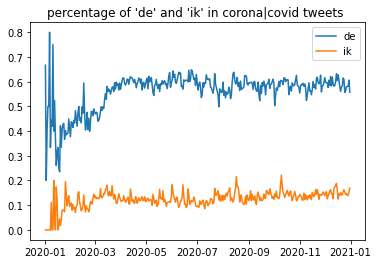

In [30]:
DATE_PATTERN = "%Y%m%d"

for word in ["de", "ik"]:
    x = []
    y = []
    for date in results[word]:
        if results[word][date][0] != 0:
            x.append(datetime.datetime.strptime(date, DATE_PATTERN))
            y.append(results[word][date][1]/results[word][date][0])
    plt.plot_date(x, y, fmt="-", label=word)

plt.title(f"percentage of 'de' and 'ik' in corona|covid tweets ")
plt.legend()
plt.show()

## Old code

In [ ]:
FILENAME202002 = "query-tokens-202002-202003.csv"
FILENAME202004 = "query-tokens-202004-202005.csv"
NON = "non-"
WEEKS = {"2020020[2-8]":"20200202","20200209|2020021[0-5]":"20200209","2020021[6-9]|2020022[0-2]":"20200216","2020022[3-9]":"20200223",\
         "2020030[1-7]":"20200301","2020030[89]|2020031[0-4]":"20200308","2020031[5-9]|2020032[01]":"20200315","2020032[2-8]":"20200322",\
                                   "20200329|20200330|2020040[1-4]":"20200329",\
         "2020040[5-9]|2020041[01]":"20200405","2020041[2-8]":"20200412","20200419|2020042[0-5]":"20200419","2020042[6-9]|2020043|2020050[1-2]":"20200426",\
         "2020050[3-9]":"20200503","2020051[0-6]":"20200510","2020051[7-9]|2020052[0-3]":"20200517"}

In [ ]:
queryTokens202002 = readData(FILENAME202004)
nonQueryTokens202002 = readData(NON+FILENAME202004)
tscoresDataQuery = {}
tscoresDataNonQuery = {}
tscores = {}
for query in queryTokens202002:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202002[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202002[query]))
    print(query)
    tscores[query] = sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))
    for x in dictTopN(tscores[query]): print(round(x[0],1),x[1])

In [ ]:
# writeData(tscores,"tscores-202004-202005.csv")

In [ ]:
tscores202002 = readData("tscores-202002-202003.csv")
tscores202004 = readData("tscores-202004-202005.csv")

In [ ]:
TOPICS = "maatregelen mondkapje anderhalve besmet rivm ".split()

data = {}
for topic in TOPICS:
    for date in tscores202002.keys():
        if not topic in data: data[topic] = {}
        data[topic][date] = tscores202002[date][topic]
    for date in tscores202004.keys():
        data[topic][date] = tscores202004[date][topic]

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

DATEFORMAT = "%Y%m%d"

fig,ax = plt.subplots(figsize=(8,4))
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
for topic in TOPICS:
    plt.plot_date([datetime.strptime(WEEKS[date],DATEFORMAT) for date in data[topic]],list(data[topic].values()),label=topic,fmt="-")
ax.set(xlabel="date (weeks)",ylabel="t-scores")
plt.title("t-scores for relevant words, comparing selected topic tweets with unselected tweets")
plt.legend()
plt.show()

**Note**: We expected only positive scores for topic words but the graph shows that *anderhalve* had negative scores  in two weeks. This means that most of the tweets containing this word are outside our topic tweets. We checked a sample of these missing tweets and most of them turned out to be on-topic, but they lacked the words *corona* and *covid*.

In [ ]:
data["anderhalve"]

In [ ]:
for date in tscores202002: 
    print("#####",date)
    for x in dictTopN(sortTscores(tscores202002[date]),n=50): print(round(x[0],1),x[1])
for date in tscores202004:
    print("#####",date)
    for x in dictTopN(sortTscores(tscores202004[date]),n=50): print(round(x[0],1),x[1])

In [ ]:
queryTokens202004 = readData(FILENAME202004)
nonQueryTokens202004 = readData(NON+FILENAME202004)
for query in queryTokens202004:
    tscoresDataQuery[query] = makeTscoreData(combineInitialHashAt(queryTokens202004[query]))
    tscoresDataNonQuery[query] = makeTscoreData(combineInitialHashAt(nonQueryTokens202004[query]))
    print(query)
    for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query]))): print(round(x[0],1),x[1])

In [ ]:
#writeData(queryTokens,"query-tokens-202004-202005.csv")
#writeData(nonQueryTokens,"non-query-tokens-202004-202005.csv")

In [ ]:
query = "2020051[7-9]|2020052[0-3]"
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[query],tscoresDataNonQuery[query])),n=40): print(round(x[0],1),x[1])

In [ ]:
FILEPATTERN = "20200601" 
QUERY= r"1.5m|1,5m|afstand.*hou|hou.*afstand|anderhalve"

queryTokens = {}
nonQueryTokens = {}
tscoresDataQuery = {}
tscoresDataNonQuery = {}
queryTokens[FILEPATTERN],nonQueryTokens[FILEPATTERN] = getTokensOfMatchedTweets(FILEPATTERN,QUERY)
tscoresDataQuery[FILEPATTERN] = makeTscoreData(queryTokens[FILEPATTERN])
tscoresDataNonQuery[FILEPATTERN] = makeTscoreData(nonQueryTokens[FILEPATTERN])
for x in dictTopN(sortTscores(tscore.computeTscore(tscoresDataQuery[FILEPATTERN],tscoresDataNonQuery[FILEPATTERN])),n=40): 
    print(round(x[0],1),x[1])

**Note**: the query "zorg" produces many false positives. There are irrelevant types ("bezorgd" and "bezorgen"), irrelevant syntactical forms ("ik zorg dat" and "Zorg dat je") and even the correct sense is not always related to the pandemic topic ("zorg voor ouderen/gehandicapten").

## Estimate coverage of crawler by looking back for messages with replies

In [ ]:
DATEPATTERN = "20200522"

fileList = sorted(os.listdir(DATADIR))
seenIds = {}
for inFileName in fileList:
    if re.search(DATEPATTERN,inFileName):
        df = pd.read_csv(DATADIR+inFileName,compression="gzip",dtype=str)
        known = 0
        unknown = 0
        for i in range(0,len(df)):
            idstr = df.iloc[i][ID]
            seenIds[idstr] = True
            replyParent = df.iloc[i][REPLYID]
            if str(replyParent) != "nan":
                if replyParent in seenIds: known += 1
                else: unknown += 1
        print("{0} {1:.3f}".format(inFileName,round(known/(known+unknown),3)))